In [1]:
#%matplotlib notebook
%matplotlib inline
#%config InlineBackend.figure_formats=['svg']
#%config InlineBackend.figure_formats=['pdf']

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 9)

from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

import scipy
import scipy.stats
import math
import numpy as np
import pandas as pd

#import ipywidgets
#from ipywidgets import interact

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import resource_stream


In [8]:
CSV_FILE_PATH = "../xps/best.csv"

#WAVELET_LABEL = "WT-K-k-C1-m3-n4-s3"
WAVELET_LABEL = "WT-K-k-C1-m3-n4-s2-2-3-3"

TAILCUT_LABEL = "Tailcut-5-10"

full_df = pd.read_csv(CSV_FILE_PATH)

ref = full_df[full_df.Type == 'Ref']
refg = ref[ref.Part == 0]    # Gamma
refp = ref[ref.Part == 1]    # Proton

tc = full_df[full_df.Type == TAILCUT_LABEL]
tcg = tc[tc.Part == 0]       # Gamma
tcp = tc[tc.Part == 1]       # Proton

wt = full_df[full_df.Type == WAVELET_LABEL]
wtg = wt[wt.Part == 0]       # Gamma
wtp = wt[wt.Part == 1]       # Proton

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
#full_df.groupby(["Type","Part","Success"]).count()

In [38]:
full_df.columns

Index(['Part', 'Id', 'Evt', 'Tel', 'Exect', 'Xtel', 'Ytel', 'Ztel', 'E',
       'Theta', 'Phi', 'X', 'Y', 'Z', 'peSum', 'Type', 'Success', 'hX', 'hY',
       'hLength', 'hWidth', 'hSize', 'hPsi', 'hPhi', 'hMiss', 'hR', 'hSkew',
       'hKurt', 'hDist', 'nIsl', 'DNpeIsl', 'DNpixIsl', 'peMaxB', 'border',
       'peMax1', 'peMin', 'nPix', 'Dshape', 'Denergy'],
      dtype='object')

# Common functions

In [160]:
def plot1(dfg, dfp, xlabel, title, bins=None, xlog=False, ylog=False, fill_style=True, fig=None, ax=None):
    if fig is None or ax is None:
        print("Make subplot")
        fig, ax = plt.subplots()
    
    if bins is None:
        global_min = min(dfg.min(), dfp.min())
        global_max = max(dfg.max(), dfp.max())
        if xlog:
            bins = np.logspace(np.log(global_min), np.log(global_max), 50)
        else:
            bins = np.linspace(global_min, global_max, 50)

    if fill_style:
        dfg.plot.hist(bins=bins,
                      alpha=0.2, color="blue", linewidth=1, histtype='bar',
                      label="Gamma ({})".format(len(dfg)),  legend=True, ax=ax)
        dfp.plot.hist(bins=bins,
                      alpha=0.2, color="red", linewidth=1, histtype='bar',
                      label="Proton ({})".format(len(dfp)), legend=True, ax=ax)
    else:
        dfg.plot.hist(bins=bins,
                      alpha=0.7, color="blue", linewidth=2, histtype='step',
                      label="Gamma ({})".format(len(dfg)),  legend=True, ax=ax)
        dfp.plot.hist(bins=bins,
                      alpha=0.7, color="red", linewidth=2, histtype='step',
                      label="Proton ({})".format(len(dfp)), legend=True, ax=ax)

    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel("counts", fontsize=20)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    ax.legend(prop={'size': 18})

    ax.set_title(title, fontsize=20)
    
    return fig, ax

In [148]:
def plot2(dfg, dfp, key, xlabel, title, bins=None, xlog=False, ylog=False, fill_style=True):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
    
    plot1(dfg[dfg.peSum < 20][key],                    dfp[dfp.peSum < 20][key],
          "", "0 to 20 NPE", bins, xlog, ylog, fill_style, fig=fig, ax=ax1)
    
    plot1(dfg[dfg.peSum >= 20][dfg.peSum < 50][key],   dfp[dfp.peSum >= 20][dfp.peSum < 50][key],
          "", "20 to 50 NPE", bins, xlog, ylog, fill_style, fig=fig, ax=ax2)
    
    plot1(dfg[dfg.peSum >= 50][dfg.peSum < 300][key],  dfp[dfp.peSum >= 50][dfp.peSum < 300][key],
          xlabel, "50 to 300 NPE", bins, xlog, ylog, fill_style, fig=fig, ax=ax3)
    
    plot1(dfg[dfg.peSum >= 300][key],                  dfp[dfp.peSum >= 300][key],
          xlabel, "300 to inf NPE", bins, xlog, ylog, fill_style, fig=fig, ax=ax4)

    fig.suptitle(title, fontsize=20)
    
    return fig, (ax1, ax2, ax3, ax4)

# NPE

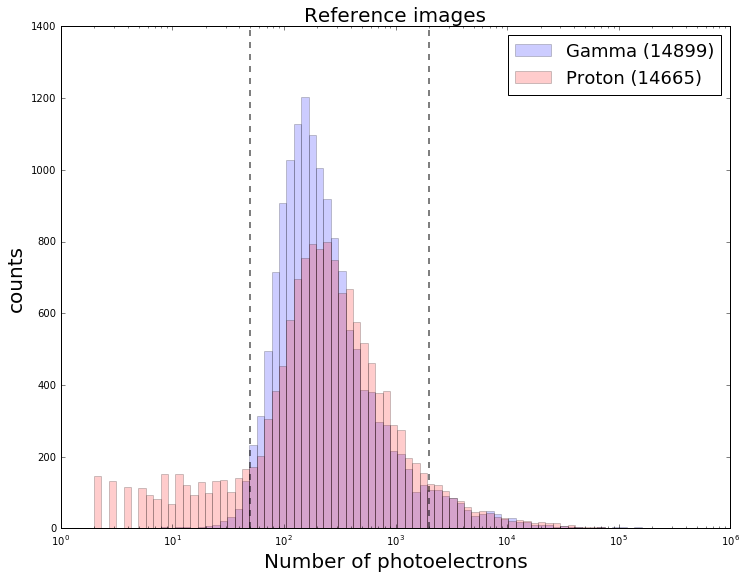

In [61]:
dfg = refg[refg.peSum > 0]['peSum']
dfp = refp[refp.peSum > 0]['peSum']

fig, ax = plot1(dfg, dfp,
                bins=np.logspace(0.1, 6., 90),
                xlabel="Number of photoelectrons",
                title="Reference images",
                xlog=True)

ax.axvline(x=50, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axvline(x=2000, linewidth=2, linestyle='--', color='black', alpha=0.5)

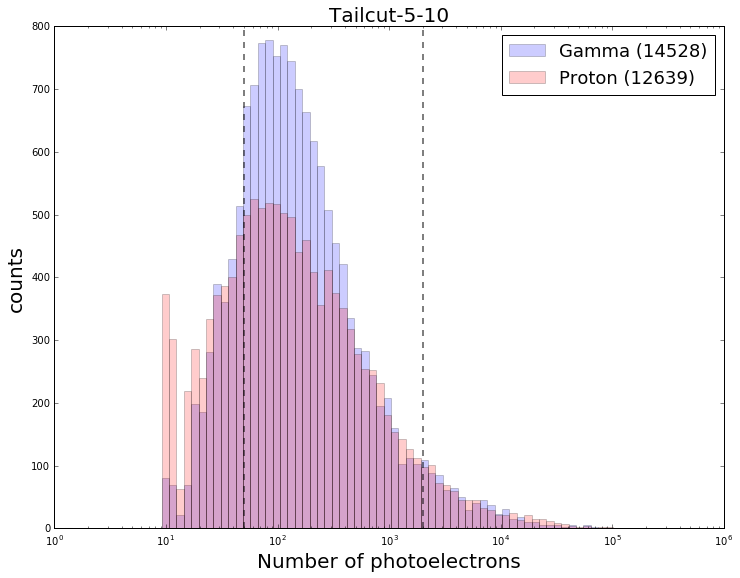

In [62]:
dfg = tcg[tcg.peSum > 0]['peSum']
dfp = tcp[tcp.peSum > 0]['peSum']

fig, ax = plot1(dfg, dfp,
                bins=np.logspace(0.1, 6., 90),
                xlabel="Number of photoelectrons",
                title=TAILCUT_LABEL,
                xlog=True)

ax.axvline(x=50, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axvline(x=2000, linewidth=2, linestyle='--', color='black', alpha=0.5)

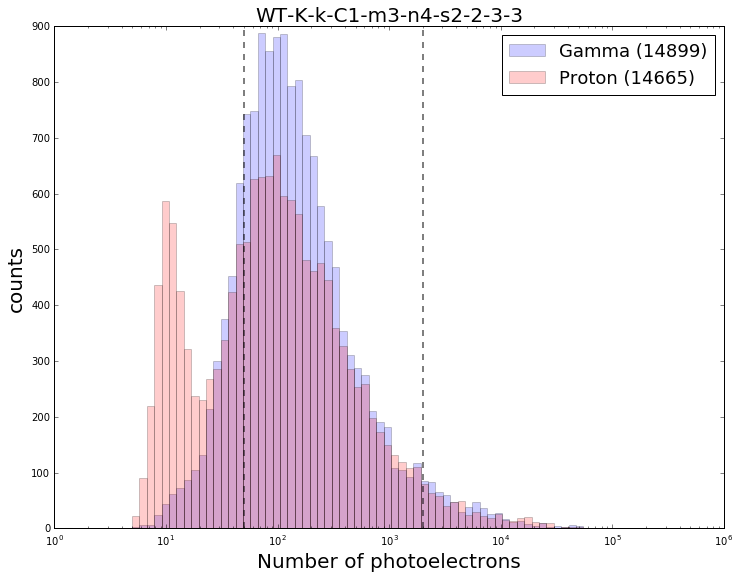

In [63]:
dfg = wtg[wtg.peSum > 0]['peSum']
dfp = wtp[wtp.peSum > 0]['peSum']

fig, ax = plot1(dfg, dfp,
                bins=np.logspace(0.1, 6., 90),
                xlabel="Number of photoelectrons",
                title=WAVELET_LABEL,
                xlog=True)

ax.axvline(x=50, linewidth=2, linestyle='--', color='black', alpha=0.5)
ax.axvline(x=2000, linewidth=2, linestyle='--', color='black', alpha=0.5)

# Angle reconstruction

# Islands

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


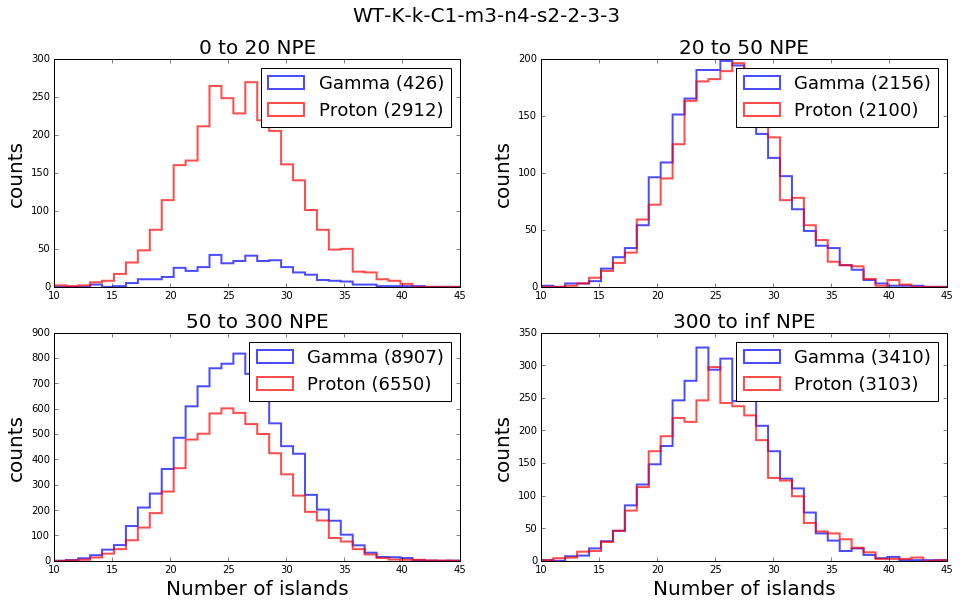

In [149]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key="nIsl",
                bins=np.linspace(10, 45, 35),
                xlabel="Number of islands",
                title=WAVELET_LABEL,
                fill_style=False)

36.201881408691406 186.9200134277344
35.240440368652344 195.34060668945312


/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32.770538330078125 355.9352111816406
31.99078750610352 753.697998046875


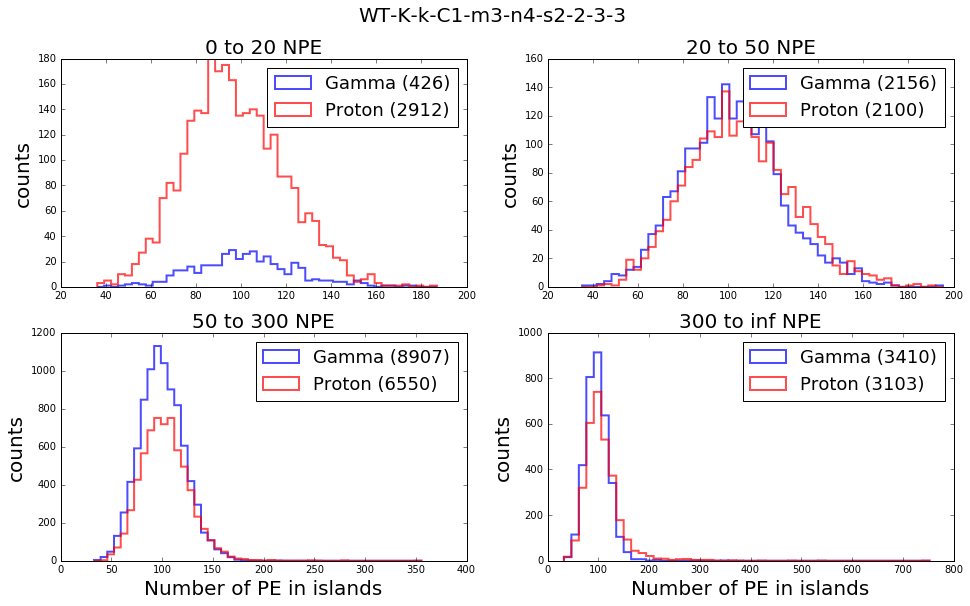

In [153]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key="DNpeIsl",
                xlabel="Number of PE in islands",
                title=WAVELET_LABEL,
                fill_style=False)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


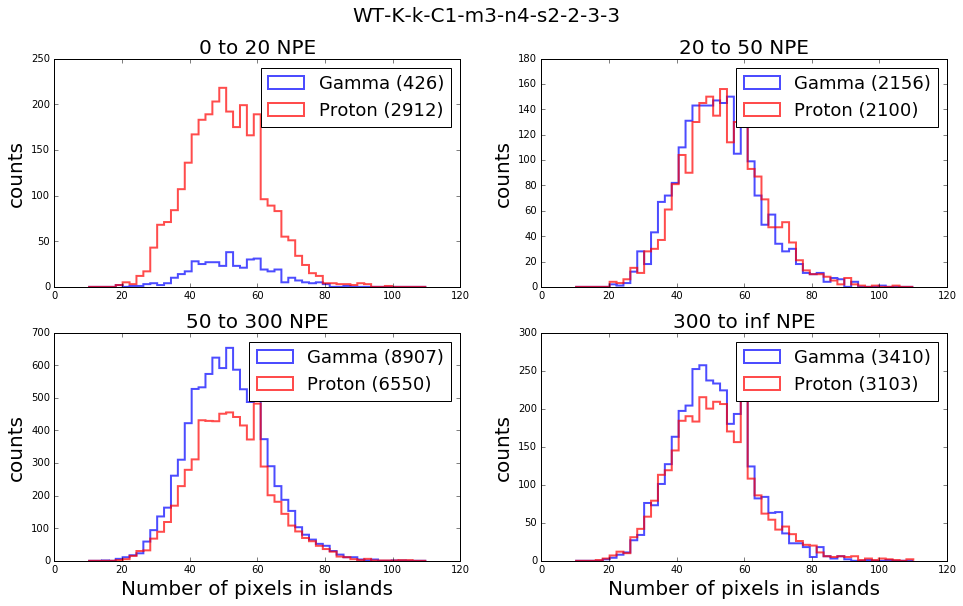

In [156]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key="DNpixIsl",
                bins=np.linspace(10, 110, 50),
                xlabel="Number of pixels in islands",
                title=WAVELET_LABEL,
                fill_style=False)

# Hillas parameters

## Length

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


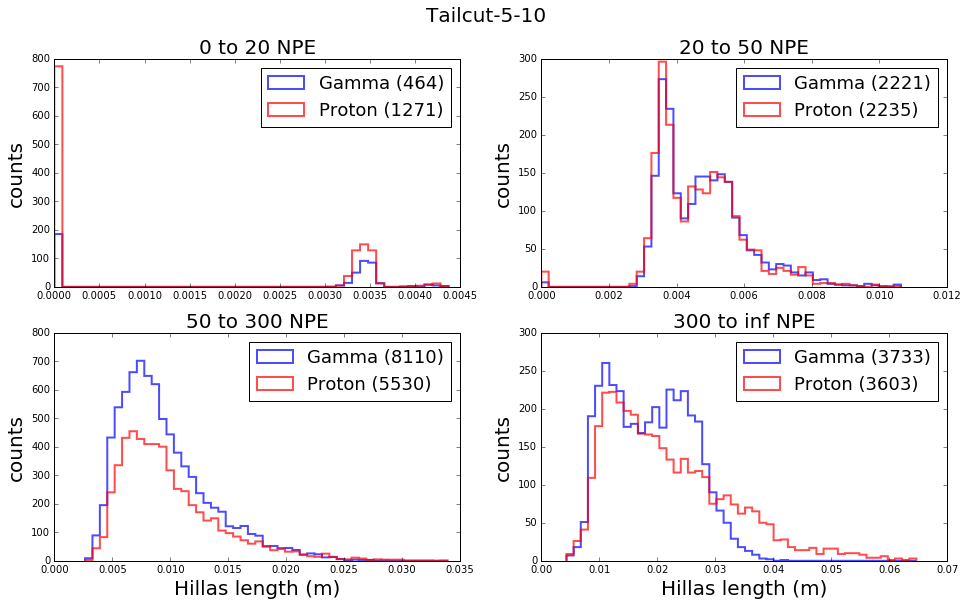

In [169]:
dfg = tcg[tcg.Success == 1]
dfp = tcp[tcp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hLength',
                xlabel="Hillas length (m)",
                title=TAILCUT_LABEL,
                fill_style=False)

0.0 0.0239325269626
4.11590317489e-11 0.0322616461127
0.00358162506205 0.0543684448396


/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.00377850096239 0.0611533178346


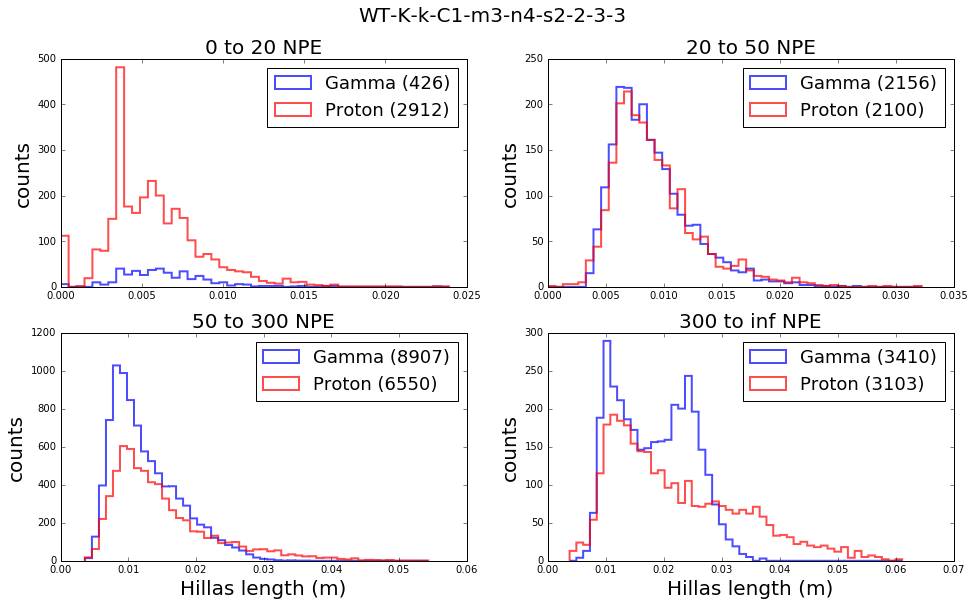

In [158]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hLength',
                xlabel="Hillas length (m)",
                title=WAVELET_LABEL,
                fill_style=False)

## Width

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


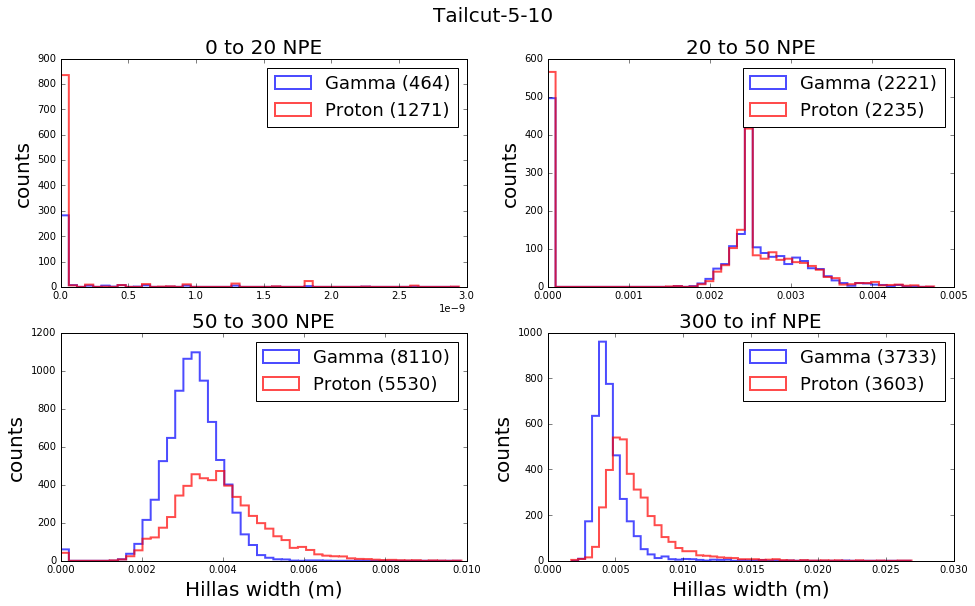

In [170]:
dfg = tcg[tcg.Success == 1]
dfp = tcp[tcp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hWidth',
                xlabel="Hillas width (m)",
                title=TAILCUT_LABEL,
                fill_style=False)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


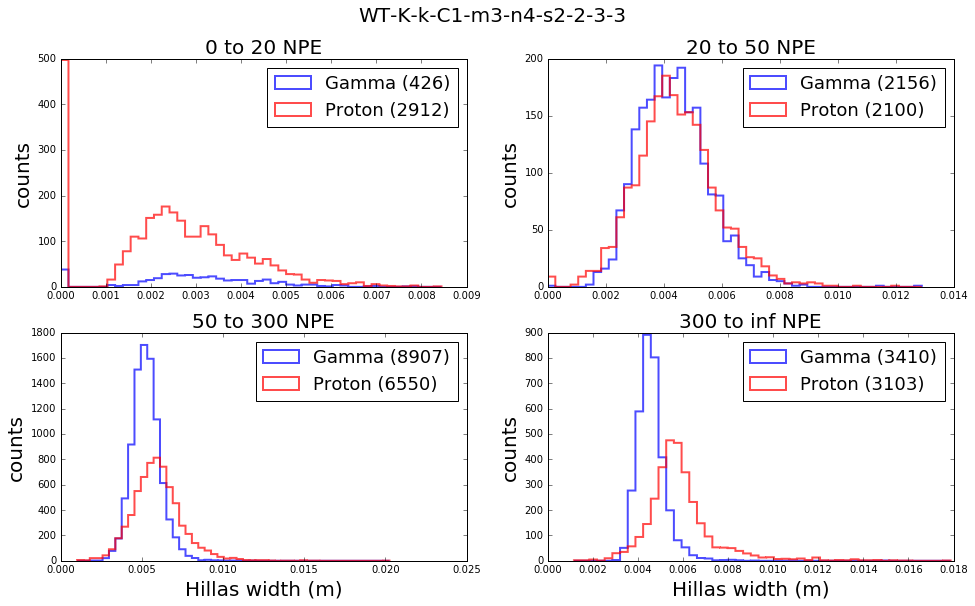

In [161]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hWidth',
                xlabel="Hillas width (m)",
                title=WAVELET_LABEL,
                fill_style=False)

## Skewness

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


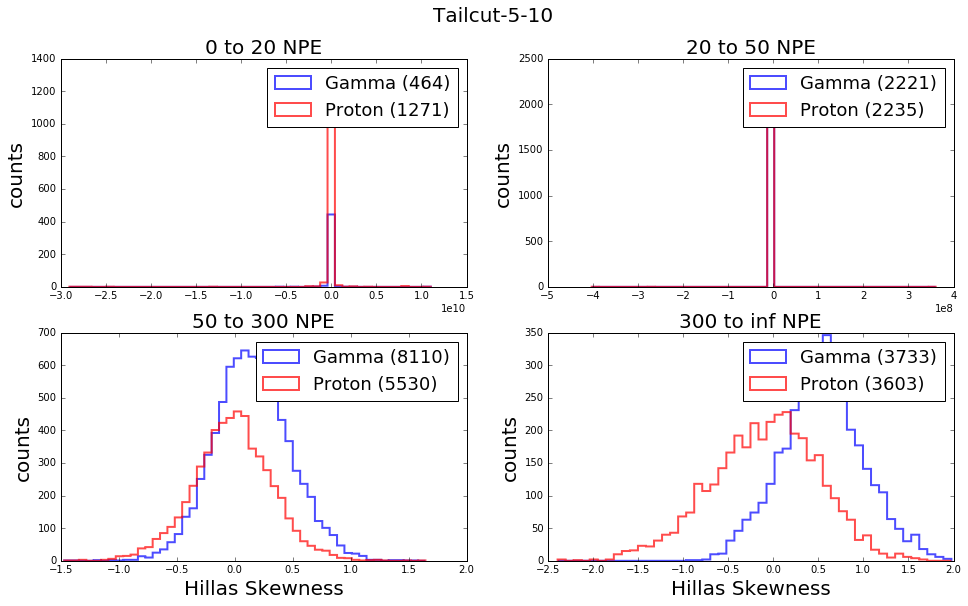

In [171]:
dfg = tcg[tcg.Success == 1]
dfp = tcp[tcp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hSkew',
                xlabel="Hillas Skewness",
                title=TAILCUT_LABEL,
                fill_style=False)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


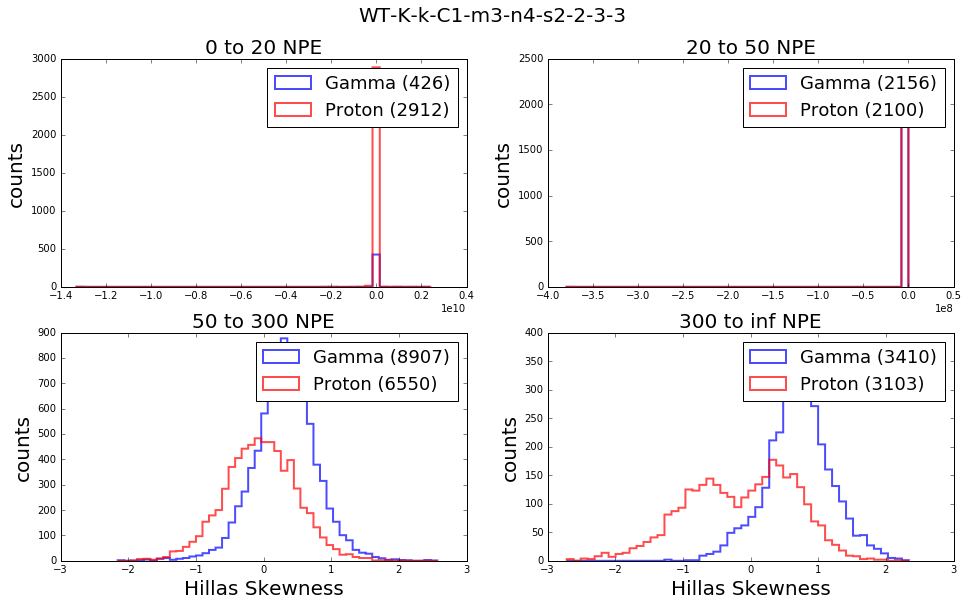

In [167]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hSkew',
                xlabel="Hillas Skewness",
                title=WAVELET_LABEL,
                fill_style=False)

## Kurtosis

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


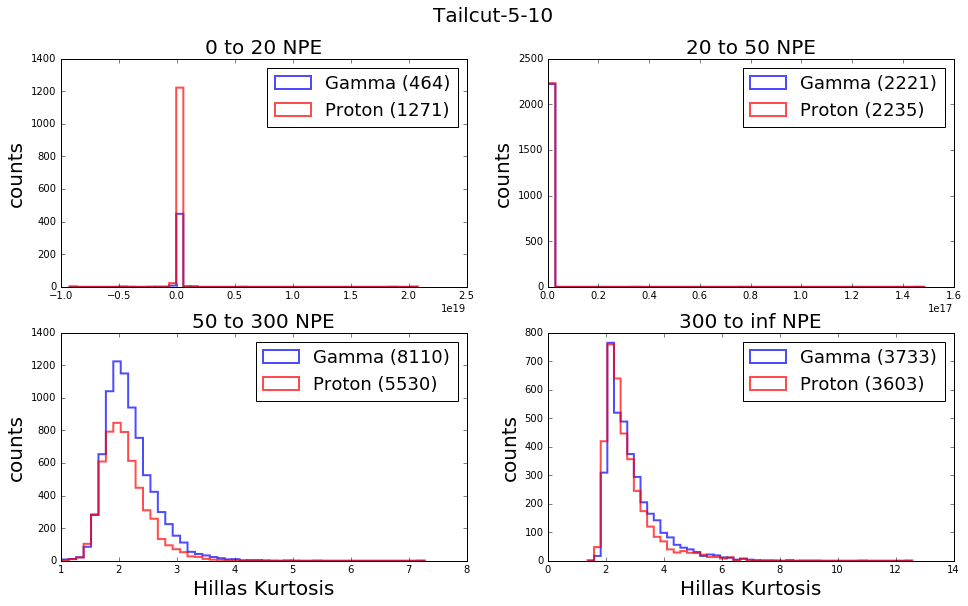

In [172]:
dfg = tcg[tcg.Success == 1]
dfp = tcp[tcp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hKurt',
                xlabel="Hillas Kurtosis",
                title=TAILCUT_LABEL,
                fill_style=False)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


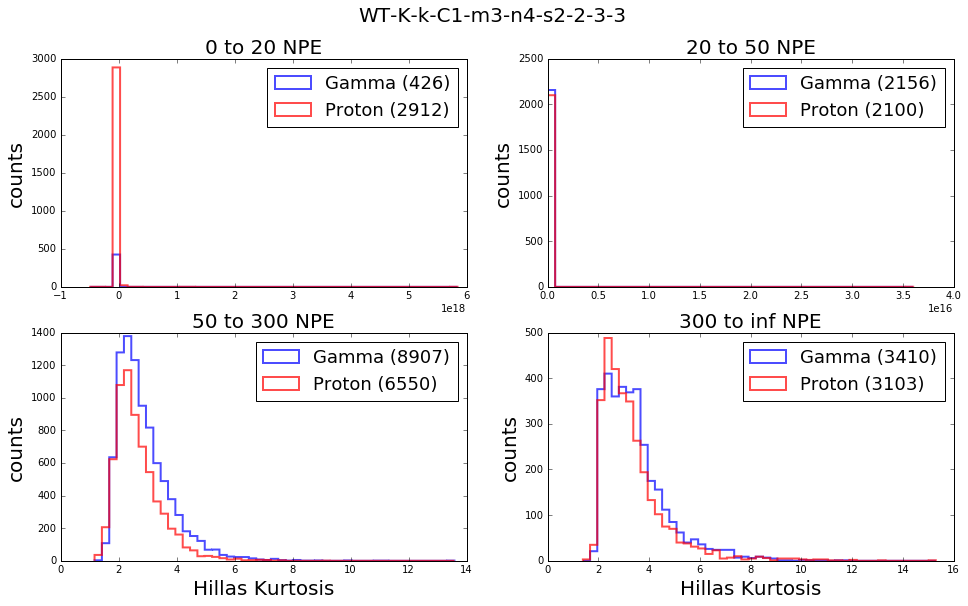

In [166]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hKurt',
                xlabel="Hillas Kurtosis",
                title=WAVELET_LABEL,
                fill_style=False)

## Other parameters

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


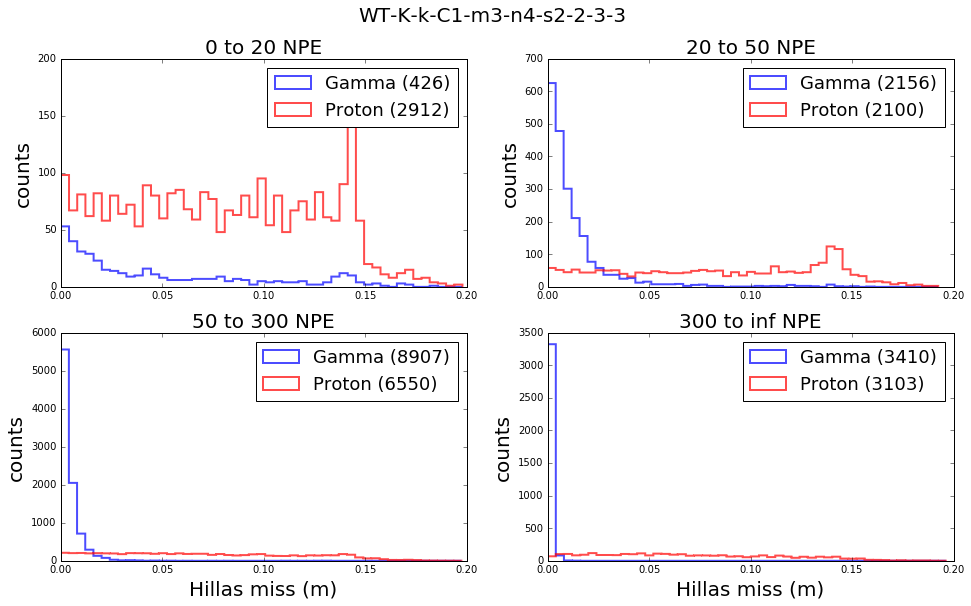

In [162]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hMiss',
                xlabel="Hillas miss (m)",
                title=WAVELET_LABEL,
                fill_style=False)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


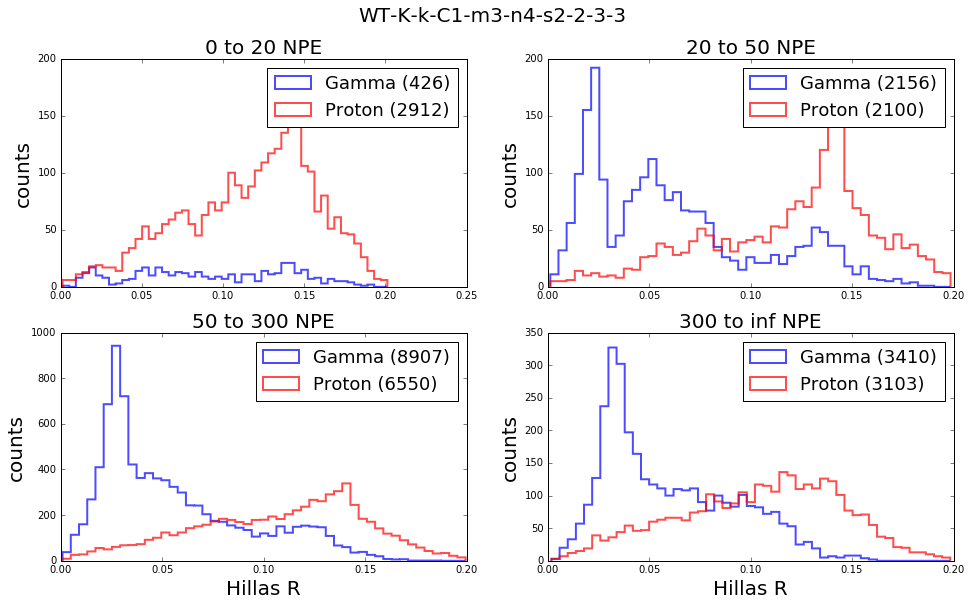

In [164]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hR',
                xlabel="Hillas R",
                title=WAVELET_LABEL,
                fill_style=False)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


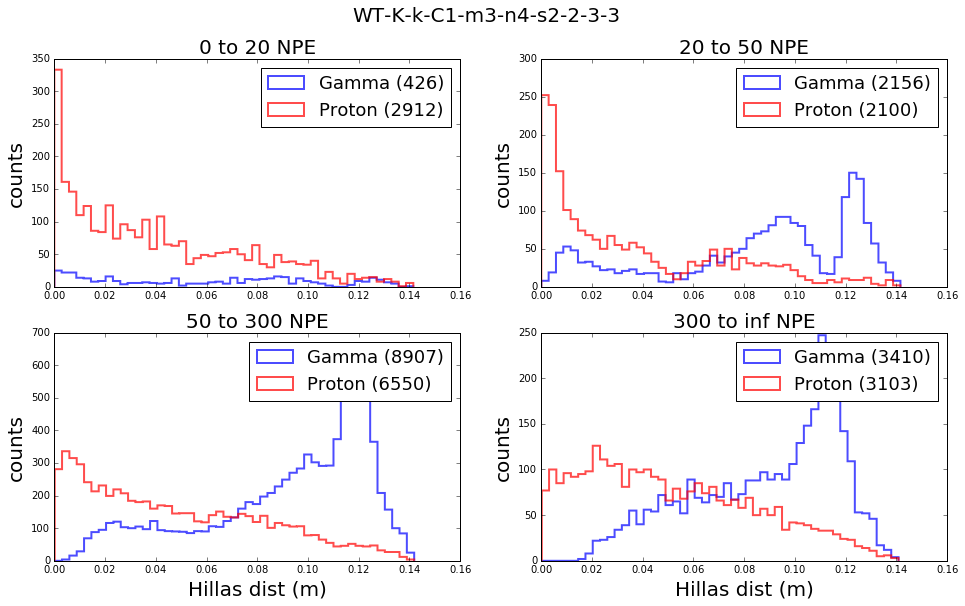

In [165]:
dfg = wtg[wtg.Success == 1]
dfp = wtp[wtp.Success == 1]

fig, ax = plot2(dfg, dfp, key='hDist',
                xlabel="Hillas dist (m)",
                title=WAVELET_LABEL,
                fill_style=False)